# A series of postprocessing and analysis steps for a protein-ligand complex.

Trajectory fixing/aligning is done with gromacs/MDAnalysis.

RSMD analysis is done with MDAnalysis. (Based on the tutorial from the documentation.)

More sophisticated contact analysis is done with PLIP. (Based on the the PLIP functions from TeachOpenCADD.)

Outline of the workflow:

1. Fix trajectory and align (stop things jumping around the box, aligning)
2. Write out small trajectory (every 10 frames of the fixed trajectory)
3. RMSD graph/matrix 
4. Contacts graph
4. PLIP graph

##### Ben Cree - Aug 2023
X - @chemcree

In [1]:
from pathlib import Path
import time
import warnings

warnings.filterwarnings("ignore")
import os
import pandas as pd
import nglview as nv
import openbabel
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

import plip
from plip.structure.preparation import PDBComplex
from plip.exchange.report import BindingSiteReport

import MDAnalysis as mda
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
from MDAnalysis.analysis.distances import distance_array
from matplotlib import cm


from MDAnalysis.analysis import rms, diffusionmap, align
from MDAnalysis.analysis.distances import dist
import subprocess

### As long as you change data_dir, have a trajectory in a subfolder (rep_dir), and rename traj/ligand_name/etc as appropriate for your system;
### This notebook will create an analysis directory in rep_dir, then place 4 images in it and also produce fixed, and smaller trajectories in data_dir.

### Runtime is a few minutes for a ~200 frame system with ~100k atoms.

#### Note: this will generate a directory called 'frames' with a .pdb file for each frame of your trajectory, this is needed for PLIP analysis and can be discarded after.

In [2]:
mda.__version__

'2.3.0'

In [3]:
openbabel.__version__

'3.1.0'

In [4]:
plip.__spec__

ModuleSpec(name='plip', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f0f9b0756a0>, origin='/home/cree/mambaforge/envs/arpeggio-env/lib/python3.8/site-packages/plip/__init__.py', submodule_search_locations=['/home/cree/mambaforge/envs/arpeggio-env/lib/python3.8/site-packages/plip'])

In [5]:
#!gmx --version

In [6]:
# i represents which rep directory will be used (i + 1 directory, i = 2 == rep3)
i = 2

In [7]:
# set data_dir to a md run, have replicas in subdirectories, rep_dir, and set reps to the number of replicas
data_dir = 'conf15/'
os.chdir(f'/home/cree/cache/md/{data_dir}')
curr_dir = f'/home/cree/cache/md/{data_dir}'
reps = 3
rep_dir = 'rep'
analysis_dir = 'analysis/'
rep_dirs = [f'{rep_dir}{i+1}/' for i in range(reps)]

# initial pdb file i.e. frame 0, and name of ligand
start_pdb = 'sys_sol.pdb'
ligand_name = "UNK"

# trajectory files to be made, final_traj will be used for all analysis
traj = 'trajectory_prod.dcd'
traj_xtc = 'trajectory_prod.xtc'
nojump_xtc = 'traj_nojump.xtc'
final_traj = 'final_traj.dcd'

In [8]:
try:
    os.mkdir(f'{curr_dir}{rep_dirs[i]}{analysis_dir}')
except:
    pass

In [9]:
try:
    os.mkdir(f'{curr_dir}{analysis_dir}')
except:
    pass

In [10]:
# assorted utility functions

def rmsd_for_atomgroups(universe, selection1, selection2=None):
    """Calulate the RMSD for selected atom groups.

    Parameters
    ----------
    universe: MDAnalysis.core.universe.Universe
        MDAnalysis universe.
    selection1: str
        Selection string for main atom group, also used during alignment.
    selection2: list of str, optional
        Selection strings for additional atom groups.

    Returns
    -------
    rmsd_df: pandas.core.frame.DataFrame
        DataFrame containing RMSD of the selected atom groups over time.
    """

    universe.trajectory[0]
    ref = universe
    rmsd_analysis = rms.RMSD(universe, ref, select=selection1, groupselections=selection2)
    rmsd_analysis.run()
    columns = [selection1, *selection2] if selection2 else [selection1]
    rmsd_df = pd.DataFrame(np.round(rmsd_analysis.results.rmsd[:, 2:], 2), columns=columns)
    rmsd_df.index.name = "frame"
    return rmsd_df

# used gmx trjconv -pbc nojump to remove ligand jumping
# !gmx trjconv -f trajectory.xtc -s ../sys_sol.pdb -pbc nojump -o trajectory_nojump.xtc
# and as a subprocess...
def run_gromacs_trjconv(input_xtc, input_pdb, output_xtc):
    """
    Runs gmx trjconv via subprocess, see gmx documentation for details.
    """
    
    command = [
        'gmx', 'trjconv',
        '-f', input_xtc,
        '-s', input_pdb,
        '-pbc', 'nojump',
        '-o', output_xtc,
    ]
    
    try:
        process = subprocess.Popen(command, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        # Provide the input '0' to the subprocess (i.e. selects entire SYSTEM)
        process.stdin.write('0\n')
        process.stdin.flush()
        
        stdout, stderr = process.communicate()
        
        if process.returncode == 0:
            print("Command executed successfully.")
        else:
            print("Error executing command:", stderr)
    except Exception as e:
        print("An error occurred:", e)


def RMSD_dist_frames(universe, selection):
    """Calculate the RMSD between all frames in a matrix.

    Parameters
    ----------
    universe: MDAnalysis.core.universe.Universe
        MDAnalysis universe.
    selection: str
        Selection string for the atomgroup to be investigated, also used during alignment.

    Returns
    -------
    array: np.ndarray
        Numpy array of RMSD values.
    """
    pairwise_rmsd = diffusionmap.DistanceMatrix(universe, select=selection)
    pairwise_rmsd.run()
    return pairwise_rmsd.results.dist_matrix

def combine(row):
    return row['type'] + '-' + row['RESTYPE'] + '-' + str(row['RESNR']) + '-' + row['RESCHAIN']

def retrieve_plip_interactions(pdb_file):
    """
    Retrieves the interactions from PLIP.

    Parameters
    ----------
    pdb_file :
        The PDB file of the complex.

    Returns
    -------
    dict :
        A dictionary of the binding sites and the interactions.
    """
    protlig = PDBComplex()
    protlig.load_pdb(pdb_file)  # load the pdb file
    for ligand in protlig.ligands:
        protlig.characterize_complex(ligand)  # find ligands and analyze interactions
    sites = {}
    # loop over binding sites
    for key, site in sorted(protlig.interaction_sets.items()):
        binding_site = BindingSiteReport(site)  # collect data about interactions
        # tuples of *_features and *_info will be converted to pandas DataFrame
        keys = (
            "hydrophobic",
            "hbond",
            "waterbridge",
            "saltbridge",
            "pistacking",
            "pication",
            "halogen",
            "metal",
        )
        # interactions is a dictionary which contains relevant information for each
        # of the possible interactions: hydrophobic, hbond, etc. in the considered
        # binding site. Each interaction contains a list with
        # 1. the features of that interaction, e.g. for hydrophobic:
        # ('RESNR', 'RESTYPE', ..., 'LIGCOO', 'PROTCOO')
        # 2. information for each of these features, e.g. for hydrophobic
        # (residue nb, residue type,..., ligand atom 3D coord., protein atom 3D coord.)
        interactions = {
            k: [getattr(binding_site, k + "_features")] + getattr(binding_site, k + "_info")
            for k in keys
        }
        sites[key] = interactions
    return sites



# print(
#     f"Number of binding sites detected in {pdb_id} : "
#     f"{len(interactions_by_site)}\n"
#     f"with {interactions_by_site.keys()}"
# )

def create_df_from_binding_site(selected_site_interactions, interaction_type="hbond"):
    """
    Creates a data frame from a binding site and interaction type.

    Parameters
    ----------
    selected_site_interactions : dict
        Precaluclated interactions from PLIP for the selected site
    interaction_type : str
        The interaction type of interest (default set to hydrogen bond).

    Returns
    -------
    pd.DataFrame :
        DataFrame with information retrieved from PLIP.
    """

    # check if interaction type is valid:
    valid_types = [
        "hydrophobic",
        "hbond",
        "waterbridge",
        "saltbridge",
        "pistacking",
        "pication",
        "halogen",
        "metal",
    ]

    if interaction_type not in valid_types:
        print("!!! Wrong interaction type specified. Hbond is chosen by default!!!\n")
        interaction_type = "hbond"

    df = pd.DataFrame.from_records(
        # data is stored AFTER the column names
        selected_site_interactions[interaction_type][1:],
        # column names are always the first element
        columns=selected_site_interactions[interaction_type][0],
    )
    return df

def residue_interactions(pdb_id, site,x):
    interactions_by_site = retrieve_plip_interactions(f"{pdb_id}.pdb")
    index_of_selected_site = 0
    selected_site = list(interactions_by_site.keys())[index_of_selected_site]
    #print(selected_site)
    dfs = []
    valid_types = [
#            "hydrophobic",
            "hbond",
            "waterbridge",
            "saltbridge",
            "pistacking",
            "pication",
            "halogen",
            "metal",
        ]
    for i in valid_types:
        dfs.append(create_df_from_binding_site(interactions_by_site[site], interaction_type=i))
    
    all_interactions = pd.concat(dfs, keys=valid_types)
    
    
    
    #all_interactions = all_interactions.dropna(axis=1) #dont drop nan if want to keep hydrophobic interactions
    
    all_interactions = all_interactions.reset_index()
    all_interactions = all_interactions.rename(columns={"level_0":"type","level_1":"id"})
    
    #oh = pd.get_dummies(a.index)  #onehot encode at some point potentially??
    
    
#    res_interactions = all_interactions.groupby('RESNR')[['type','RESTYPE', 'DIST', 'ANGLE',]].agg(lambda x: list(x)).reset_index()
#    res_interactions['id'] = pdb_id[x]


    return all_interactions

def analyse_traj(pdb_id, nframes, site_id):
    pdb_list = [f"{pdb_id}{i}" for i in range(1, nframes + 1)]
    dat = []
    for i in range(nframes):
        print('analysing traj frame ', pdb_list[i])
        interactions_by_site = retrieve_plip_interactions(pdb_list[i]+'.pdb')
        print(interactions_by_site)
        index_of_selected_site = 0
        selected_site = list(interactions_by_site.keys())[index_of_selected_site]
        print(selected_site)
        #print(selected_site)

        itrns = residue_interactions(pdb_id+str(i), selected_site, site_id)
        print(itrns)
        dat.append(itrns)
    return dat

In [11]:
f'Using :{rep_dirs[i]}'

'Using :rep3/'

In [12]:
md_universe = mda.Universe(start_pdb, f'{curr_dir}{rep_dirs[i]}{traj}')

In [13]:
with mda.Writer(f'{curr_dir}{rep_dirs[i]}{traj_xtc}', md_universe) as W:
    for ts in md_universe.trajectory:
        W.write(md_universe)

In [14]:
run_gromacs_trjconv(f'{curr_dir}{rep_dirs[i]}{traj_xtc}', start_pdb, f'{curr_dir}{rep_dirs[i]}{nojump_xtc}')

Command executed successfully.


In [15]:
# now align the trajectory
# first print current rmsd
mobile = mda.Universe(start_pdb, f'{rep_dirs[i]}{nojump_xtc}')
ref = mda.Universe(start_pdb, f'{rep_dirs[i]}{nojump_xtc}')
mobile.trajectory[-1]  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame

mobile_ca = mobile.select_atoms('name CA')
ref_ca = ref.select_atoms('name CA')
unaligned_rmsd = rms.rmsd(mobile_ca.positions, ref_ca.positions, superposition=False)
print(f"Unaligned RMSD: {unaligned_rmsd:.2f}")

Unaligned RMSD: 71.29


In [16]:
# align to first frame
aligner = align.AlignTraj(mobile, ref, select='backbone',
                           filename=f'{curr_dir}{rep_dirs[i]}{final_traj}').run()
mobile = mda.Universe(start_pdb, f'{curr_dir}{rep_dirs[i]}{final_traj}')



mobile.trajectory[-1]  # set mobile trajectory to last frame
ref.trajectory[2]  # set reference trajectory to third frame

aligned_rmsd_3 = rms.rmsd(mobile.atoms.positions, ref.atoms.positions, superposition=False)
print(f"Aligned RMSD, all-atom: {aligned_rmsd_3:.2f}")



Aligned RMSD, all-atom: 541.82


In [17]:
# write out a small (1/10th) size trajectory for sharing
final = mda.Universe(f'{curr_dir}{rep_dirs[i]}{final_traj}')

with mda.Writer(f'{curr_dir}{rep_dirs[i]}final_small.dcd', final.atoms.n_atoms) as w:
    for ts in final.trajectory[::10]:
        w.write(final)

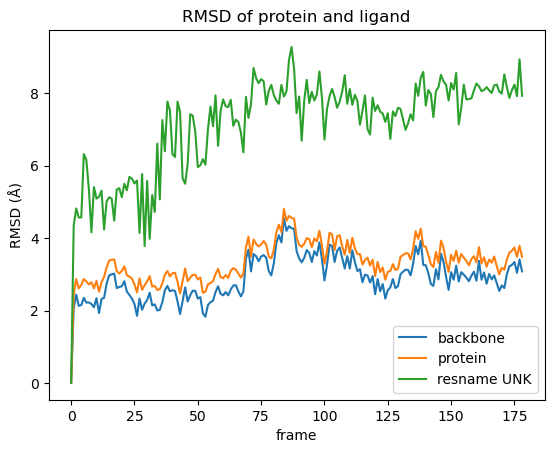

In [18]:
final_u = mda.Universe(start_pdb, f'{curr_dir}{rep_dirs[i]}{final_traj}')
rmsd = rmsd_for_atomgroups(final_u, "backbone", ["protein", f"resname {ligand_name}"])
rmsd.head()
rmsd.plot(title="RMSD of protein and ligand")
plt.ylabel("RMSD (Å)")
plt.savefig(f'{curr_dir}{rep_dirs[i]}{analysis_dir}rep_{i+1}_rmsd_prot_lig.png', dpi=300)

In [19]:
dist_matrix_protein = RMSD_dist_frames(final_u, "protein")
dist_matrix_ligand = RMSD_dist_frames(final_u, f"resname {ligand_name}")

# get maximal distance between all frames
max_dist = max(np.amax(dist_matrix_ligand), np.amax(dist_matrix_protein))


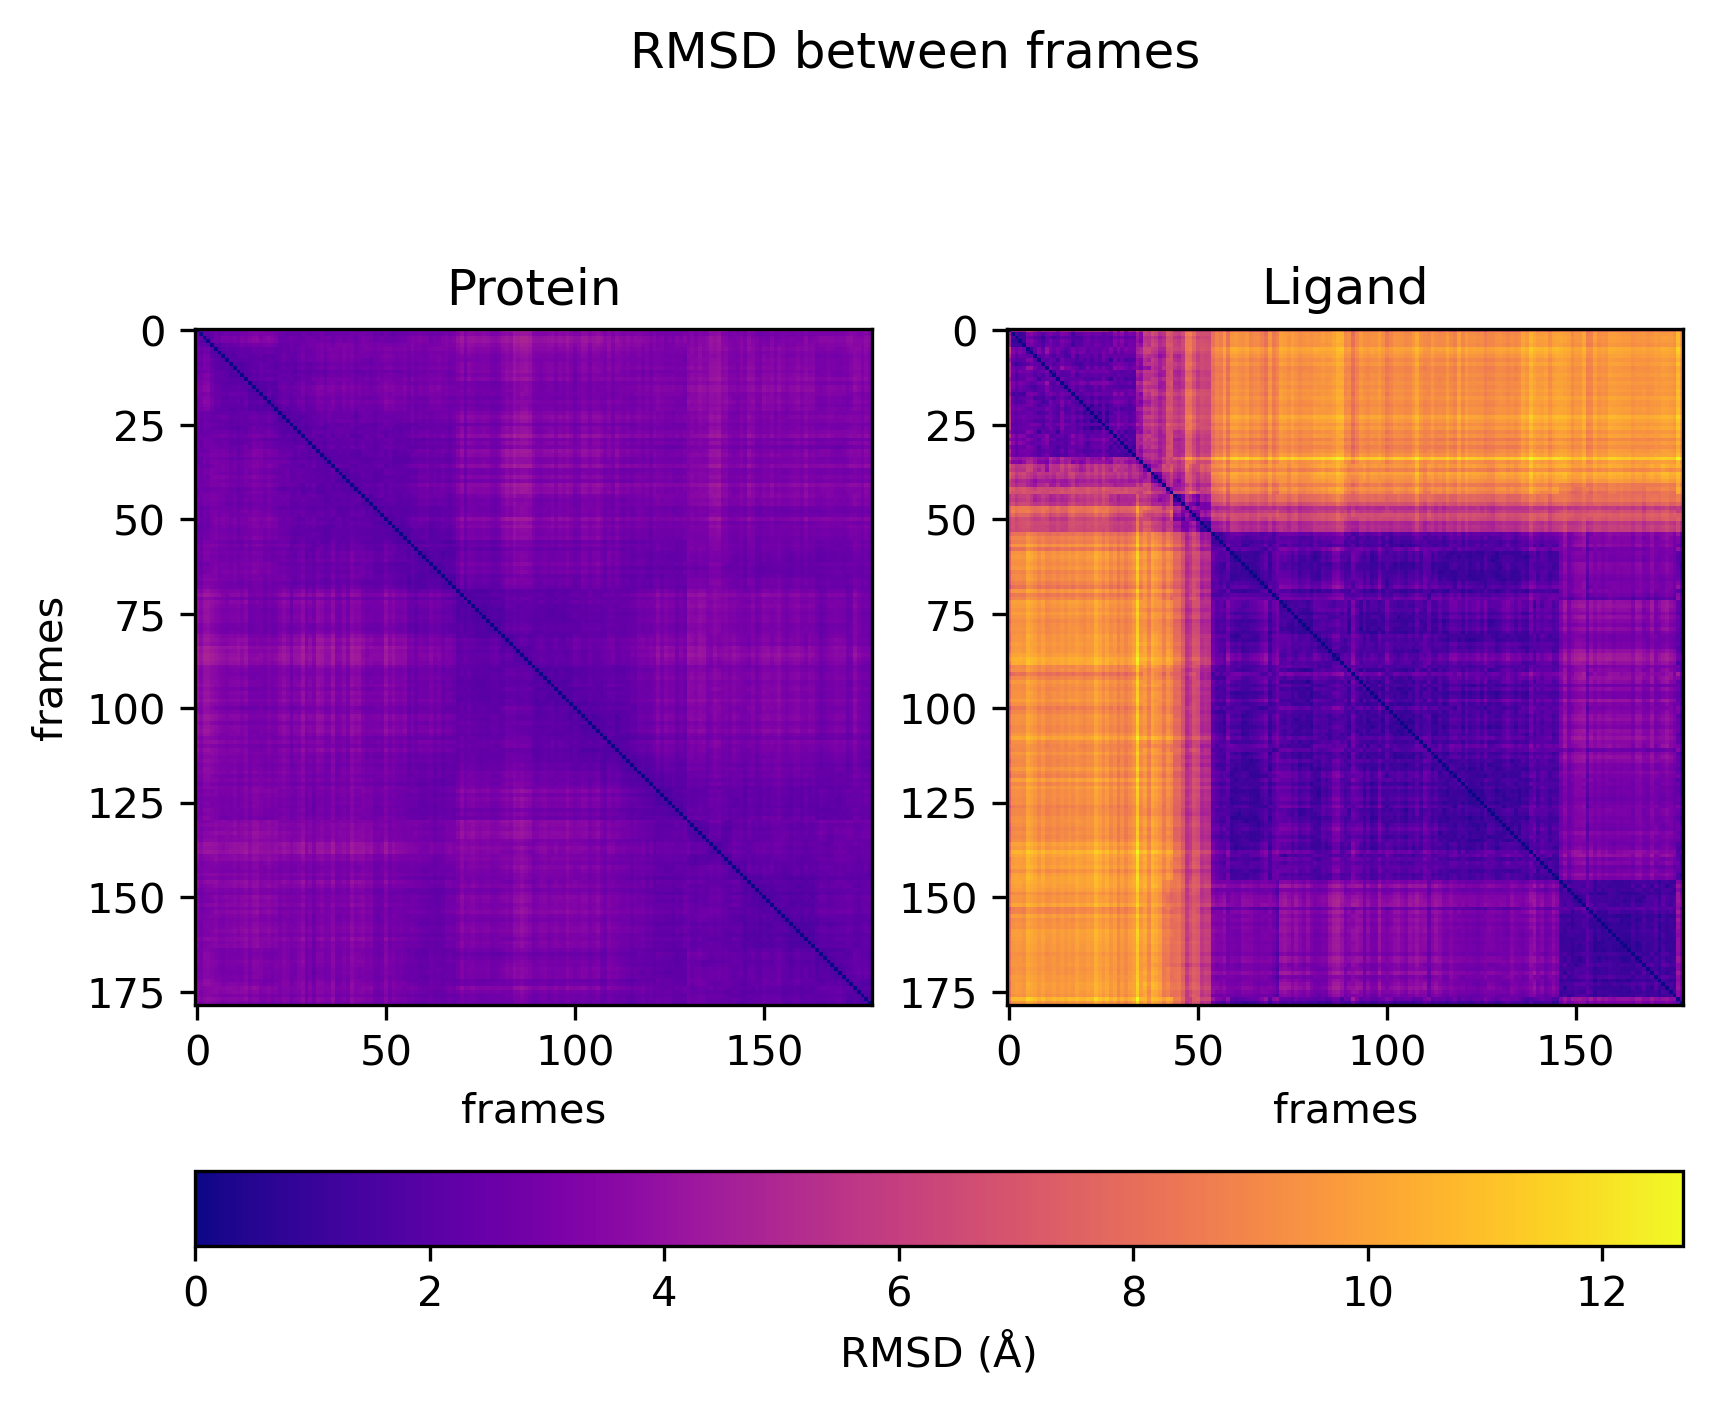

In [20]:
fig, ax = plt.subplots(1, 2, dpi=300)
fig.suptitle("RMSD between frames")

# protein image
img1 = ax[0].imshow(dist_matrix_protein, cmap="plasma", vmin=0, vmax=max_dist)
ax[0].title.set_text("Protein")
ax[0].set_xlabel("frames")
ax[0].set_ylabel("frames")

# ligand image
img2 = ax[1].imshow(dist_matrix_ligand, cmap="plasma", vmin=0, vmax=max_dist)
ax[1].title.set_text("Ligand")
ax[1].set_xlabel("frames")

fig.colorbar(img1, ax=ax, orientation="horizontal", fraction=0.1, label="RMSD (Å)");
fig.savefig(f'{curr_dir}{rep_dirs[i]}{analysis_dir}rep_{i+1}_rmsdmatrix.png')

Done timeframe (ns): 0.0
Done timeframe (ns): 2.0000000656990813
Done timeframe (ns): 4.000000131398163
Done timeframe (ns): 6.000000197097243
Done timeframe (ns): 8.000000262796325
Done timeframe (ns): 10.000000328495407
Done timeframe (ns): 12.000000394194487
Done timeframe (ns): 14.000000459893569
Done timeframe (ns): 16.00000052559265
Done timeframe (ns): 18.00000059129173
Done timeframe (ns): 20.000000656990814
Done timeframe (ns): 22.000000722689894
Done timeframe (ns): 24.000000788388974
Done timeframe (ns): 26.000000854088057
Done timeframe (ns): 28.000000919787137
Done timeframe (ns): 30.00000098548622
Done timeframe (ns): 32.0000010511853
Done timeframe (ns): 34.000001116884384
Done timeframe (ns): 36.00000118258346
Done timeframe (ns): 38.000001248282544
Done timeframe (ns): 40.00000131398163
Done timeframe (ns): 42.000001379680704
Done timeframe (ns): 44.00000144537979
Done timeframe (ns): 46.00000151107887
Done timeframe (ns): 48.00000157677795
Done timeframe (ns): 50.0000

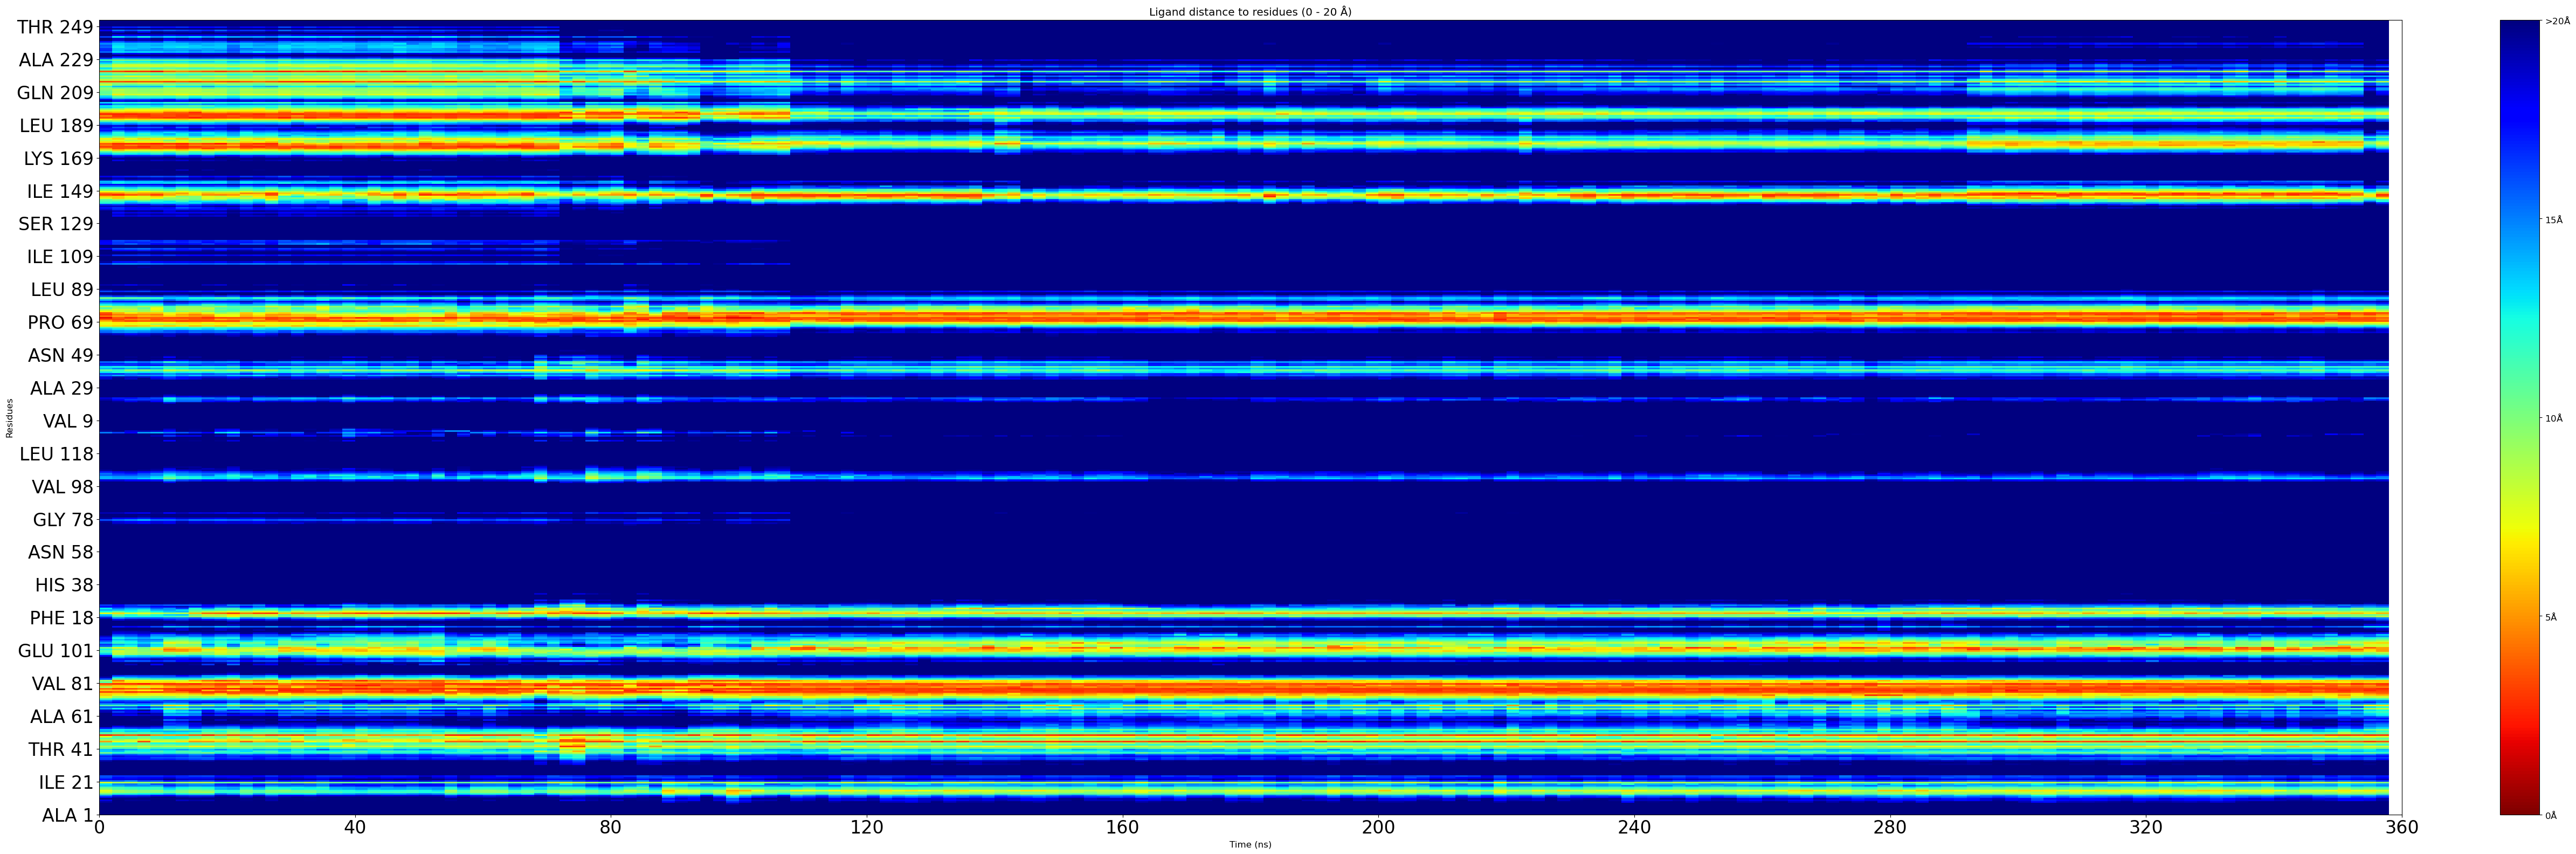

In [21]:
protein = final_u.select_atoms('protein')
substrate = final_u.select_atoms("resname UNK")
output_filename = f'{curr_dir}{analysis_dir}rep_{i+1}_data_distance_map.dat'

column_titles = ['time(ps)', ]
residues = []
for j, residue in enumerate(protein.residues, start=1):
    column_titles.append(residue.resname + '.' + str(residue.resid) + '.' + str(j))
    residues.append(residue.atoms.select_atoms('not name H*'))

assert len(protein.residues) == len(residues), 'There should be heavy atom indices for each residue'

data = []
for ts in final_u.trajectory[::1]:
    row = [ts.time, ]
    for res_hatoms in residues:
        mindst = np.min(distance_array(res_hatoms.positions, substrate.positions,
                                       box=ts.dimensions))
        row.append(mindst)
    data.append(row)
    print("Done timeframe (ns):", ts.time * 2)

np.savetxt(output_filename, data, fmt='%.2f', header='\t'.join(column_titles))

data_filepath = output_filename
plot_output_filepath = f'{curr_dir}{rep_dirs[i]}{analysis_dir}rep_{i+1}_distance_map.png'

matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(48, 16))
plt.subplot(1, 1, 1)
plt.title('Ligand distance to residues (0 - 20 Å)')
plt.xlabel('Time (ns)')
plt.ylabel('Residues')

resnames = open(data_filepath).readline().split('time(ps)')[1].split()
resnames = [n.split('.')[0] + ' ' + n.split('.')[1] for n in resnames]

data = np.loadtxt(data_filepath, comments='#')
assert len(resnames) == data.shape[1] - 1, 'The number of residues does not correspond to the number of data columns'

heatmap = data[:, list(range(1, len(resnames) + 1,))]
heatmap = heatmap.T
#heatmap = filtered_df
contactmap = plt.pcolormesh(heatmap, cmap=cm.jet_r, vmin=0, vmax=20,)

tick_indices = np.array(list(range(0, len(resnames) , 20)))
plt.yticks(range(0,len(resnames),20), [resnames[i] for i in tick_indices], fontsize=24)

cbar = plt.colorbar(contactmap, ticks=[0, 5, 10, 15, 20], fraction=0.02, pad=0.04)
cbar.ax.set_yticklabels(['0$\\rm \AA$', '5$\\rm \AA$', '10$\\rm \AA$', '15$\\rm \AA$', '>20$\\rm \AA$'])

plt.xticks(range(0,184,20),labels=range(0,368,40), fontsize=24)
plt.tight_layout()
plt.savefig(plot_output_filepath, dpi=500)

In [22]:
try:
    os.mkdir(f'{curr_dir}{rep_dirs[i]}frames')
except:
    print(f'{curr_dir}{rep_dirs[i]} frames already exists.')
    pass
selection = "not resname HOH"
frames = []
# writing out each frame of the trajectory (minus water because it slows down contact analysis)
# has to be done, because plip will only accept single frame pdbs, can be removed after
for ts in final_u.trajectory:
    print(f"Processing frame {ts.frame}")
    atom_selection = final_u.select_atoms(selection, updating=True)
    frames.append(atom_selection)
    print(atom_selection.radius_of_gyration()) # if this number changes it means its really writing different frames
    with mda.Writer(f"{curr_dir}{rep_dirs[i]}frames/traj_{ts.frame}.pdb") as pdb:
        pdb.write(atom_selection)

Processing frame 0
23.568215064630742
Processing frame 1
23.784824196653922
Processing frame 2
24.005702934799682
Processing frame 3
23.99896496602179
Processing frame 4
23.765146401580118
Processing frame 5
23.453995354960444
Processing frame 6
23.536710981569662
Processing frame 7
23.449919448341124
Processing frame 8
23.4742723572424
Processing frame 9
23.601699630514734
Processing frame 10
23.535967194130524
Processing frame 11
23.681741809299986
Processing frame 12
23.636803056411722
Processing frame 13
23.46112269937474
Processing frame 14
23.682388018888147
Processing frame 15
23.513906012675534
Processing frame 16
23.516407895881887
Processing frame 17
23.724883040005
Processing frame 18
23.472576295825927
Processing frame 19
23.504468467340015
Processing frame 20
23.533429206587417
Processing frame 21
23.638590717974616
Processing frame 22
23.75641373253891
Processing frame 23
23.78216825331452
Processing frame 24
23.7457137390611
Processing frame 25
23.741165728849236
Process

In [23]:
print('Trajectory frames: ', final_u.trajectory.n_frames)

Trajectory frames:  179


In [24]:
pdb_id = f'{curr_dir}{rep_dirs[i]}frames/traj_'
# last argument determines which binding site is analysed
# this is the big list of dataframes with all the data in, if you want to explore
traj_analysis = analyse_traj(pdb_id, final_u.trajectory.n_frames-1, 0) 

analysing traj frame  /home/cree/cache/md/conf15/rep3/frames/traj_1
{'UNK:D:1': {'hydrophobic': [('RESNR', 'RESTYPE', 'RESCHAIN', 'RESNR_LIG', 'RESTYPE_LIG', 'RESCHAIN_LIG', 'DIST', 'LIGCARBONIDX', 'PROTCARBONIDX', 'LIGCOO', 'PROTCOO'), (80, 'TYR', 'A', 1, 'UNK', 'D', '3.40', 7518, 1214, (-31.385, 13.171, -33.364), (-30.749, 16.074, -35.007))], 'hbond': [('RESNR', 'RESTYPE', 'RESCHAIN', 'RESNR_LIG', 'RESTYPE_LIG', 'RESCHAIN_LIG', 'SIDECHAIN', 'DIST_H-A', 'DIST_D-A', 'DON_ANGLE', 'PROTISDON', 'DONORIDX', 'DONORTYPE', 'ACCEPTORIDX', 'ACCEPTORTYPE', 'LIGCOO', 'PROTCOO'), (177, 'ASN', 'C', 1, 'UNK', 'D', True, '3.11', '3.64', '114.10', True, 6354, 'Nam', 7503, 'N2', (-33.47, 11.075, -26.462), (-36.344, 12.857, -27.809)), (194, 'VAL', 'C', 1, 'UNK', 'D', False, '2.51', '2.91', '102.94', True, 6583, 'Nam', 7511, 'N1', (-32.486, 17.341, -22.184), (-33.239, 20.152, -22.313)), (195, 'ASP', 'C', 1, 'UNK', 'D', False, '2.36', '3.34', '164.38', True, 6599, 'Nam', 7511, 'N1', (-32.486, 17.341, -22.

In [25]:
# Create a list of DataFrames with identifiers
concatenated_dfs = []
for k, df in enumerate(traj_analysis):
    df['ts'] = f'{k+1}'
    concatenated_dfs.append(df)

# Concatenate the DataFrames
concatenated_df = pd.concat(concatenated_dfs, ignore_index=True)

In [26]:
# Set the 'Source' column as the index
concatenated_df.set_index('ts', inplace=True)

In [27]:
# Expand list columns into separate rows
expanded_df = concatenated_df.explode(['type', 'RESTYPE', 'DIST', 'ANGLE'])
expanded_df['RES'] = expanded_df.apply(combine, axis=1)
expanded_df['timestep'] = expanded_df.index

In [28]:
#plip contacts analysis for the first frame
traj_analysis[0]

,type,id,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST_H-A,...,TARGET_IDX,TARGET_TYPE,COORDINATION,LOCATION,RMS,GEOMETRY,COMPLEXNUM,METALCOO,TARGETCOO,ts
0,hbond,0,193,THR,C,1,UNK,D,True,2.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,hbond,1,195,ASP,C,1,UNK,D,False,3.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,hbond,2,80,TYR,A,1,UNK,D,True,2.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,hbond,3,71,THR,C,1,UNK,D,False,1.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [29]:
sns.set_palette('deep')
sns.set_theme(style='darkgrid')
result = expanded_df

# Convert 'timestep' to numeric (if it's not already)
result['timestep'] = pd.to_numeric(result['timestep'], errors='coerce')

# Convert 'DIST_H-A' to numeric (if it's not already)
result['DIST_H-A'] = pd.to_numeric(result['DIST_H-A'], errors='coerce')

# Select the relevant columns for the heatmap
heatmap_data = result[['timestep', 'RES', 'DIST_H-A']]

heatmap_data['DIST_H-A'] = heatmap_data['DIST_H-A'].fillna(3.75)

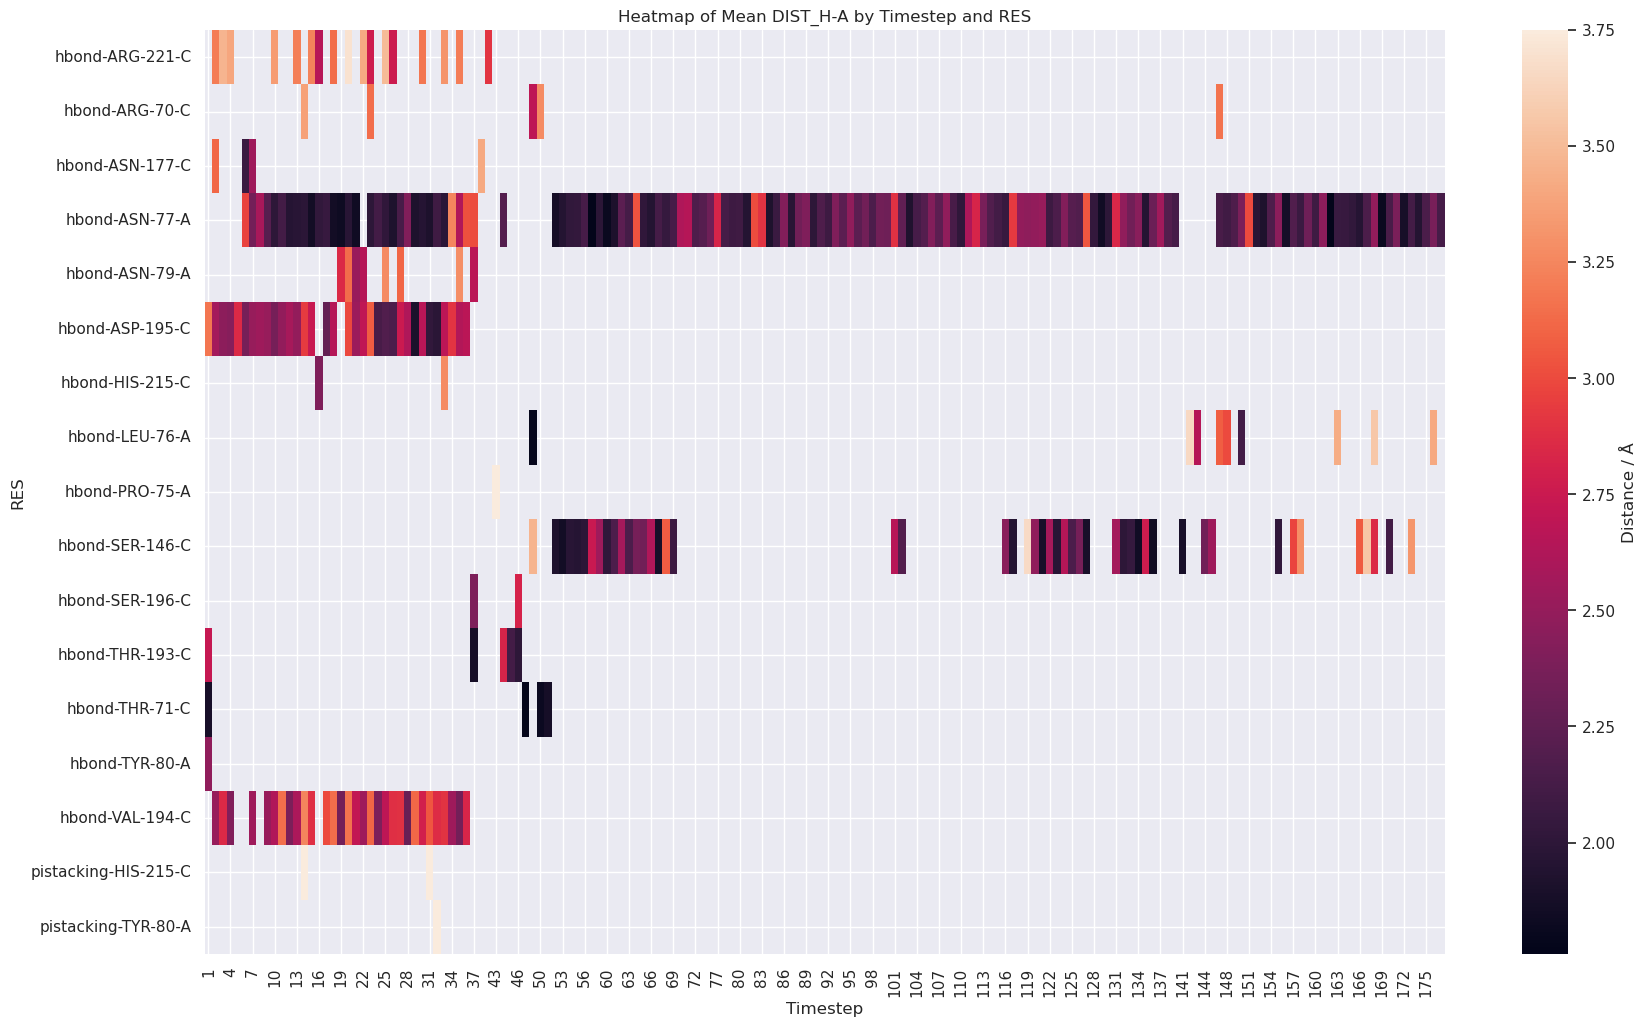

In [30]:
# Pivot the data to create a matrix suitable for heatmap
heatmap_matrix = heatmap_data.pivot_table(index='RES', columns='timestep', values='DIST_H-A', aggfunc='mean', dropna=False)

# Sort the timestep values
sorted_timesteps = sorted(heatmap_matrix.columns)

# Reindex the columns of heatmap_matrix based on sorted_timesteps
heatmap_matrix = heatmap_matrix[sorted_timesteps]

# Create the heatmap
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.heatmap(heatmap_matrix, annot=False, fmt=".2f", cmap="rocket", cbar_kws={'label': 'Distance / Å'})
sns.set_style('dark')
# Set labels and title
plt.xlabel("Timestep")
plt.ylabel("RES")
plt.title("Heatmap of Mean DIST_H-A by Timestep and RES")
plt.savefig(f'{curr_dir}{rep_dirs[i]}{analysis_dir}rep_{i+1}_plip_heatmap.png', dpi=500, bbox_inches="tight", format="png")
plt.savefig(f'{curr_dir}{rep_dirs[i]}{analysis_dir}rep_{i+1}_plip_heatmap.svg', dpi=500, bbox_inches="tight", format="svg")
# Show the plot
plt.show()